In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
import os
os.getcwd()
df = pd.read_csv('summary.csv')

In [164]:
df_filt = df.dropna(subset=["pa_approved"])

provider = df['bin'].unique()
drug = df['drug'].unique()
year = df['calendar_year'].unique()

tdf = df_filt[["calendar_year", "calendar_month"]].drop_duplicates()
tdf['year-month'] = tdf["calendar_year"].map(str)+'-'+tdf['calendar_month'].map(str)
tdf = tdf.set_index(["calendar_year", "calendar_month"])
tdf["volume"] = 0

for j in year:
    df_cal = df_filt[df_filt['calendar_year']==j]
    for i in range(1, 13):
        PA_requests = len(df_cal[df_cal['calendar_month']==i])        
        tdf.loc[(j, i), "volume"] = PA_requests

In [169]:
tdf = tdf.reset_index(drop=True)

           year-month  volume
year-month                   
2017-01-01 2017-01-01   13766
2017-02-01 2017-02-01   12769
2017-03-01 2017-03-01   14694
2017-04-01 2017-04-01   12742
2017-05-01 2017-05-01   13717


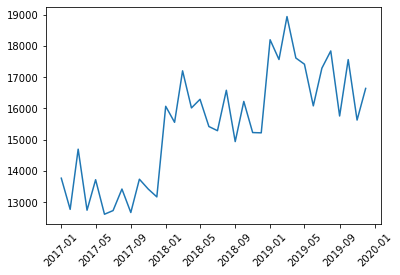

In [174]:
date = pd.Series([datetime. strptime(i,'%Y-%m') for i in tdf["year-month"]])
tdf_n = pd.concat([date, tdf["volume"]], axis=1)
tdf_n = tdf_n.rename(columns = {0:"year-month"})
tdf_n.index = tdf_n["year-month"]
print(tdf_n.head())
plt.plot(tdf_n["year-month"], tdf_n["volume"])
plt.xticks(rotation = 45)
plt.show()

# The following analysis is based on the tutorial without any time series correction 
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

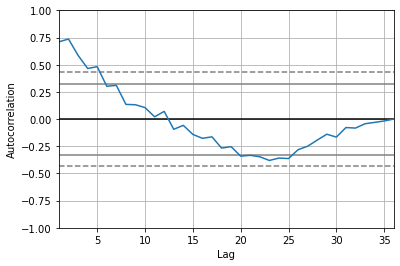

In [56]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(tdf["volume"])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -293.472
Date:                Wed, 19 May 2021   AIC                            598.944
Time:                        10:51:24   BIC                            608.276
Sample:                             0   HQIC                           602.165
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2384      0.134     -1.774      0.076      -0.502       0.025
ar.L2          0.2215      0.247      0.896      0.370      -0.263       0.706
ar.L3         -0.1208      0.150     -0.804      0.4

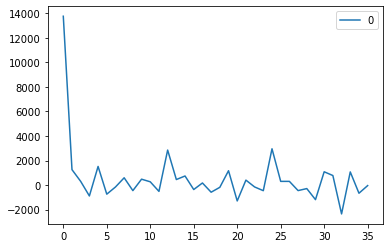

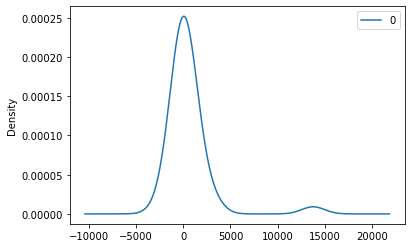

                  0
count     36.000000
mean     544.591928
std     2493.866911
min    -2355.189288
25%     -456.400480
50%      215.723875
75%      747.188591
max    13766.000000


In [58]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(tdf["volume"], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe()) #suggest a non-zero mean in the rediduals

predicted=15817.721734, expected=15217.000000
predicted=15129.895634, expected=18195.000000
predicted=17408.314582, expected=17563.000000
predicted=18746.999391, expected=18937.000000
predicted=18116.294448, expected=17611.000000
predicted=17711.036657, expected=17413.000000
predicted=17257.687921, expected=16080.000000
predicted=16096.435147, expected=17286.000000
predicted=17064.356743, expected=17837.000000
predicted=18246.429545, expected=15756.000000
predicted=16313.679155, expected=17560.000000
predicted=16378.629477, expected=15626.000000
predicted=16680.858512, expected=16638.000000
Test RMSE: 1297.416


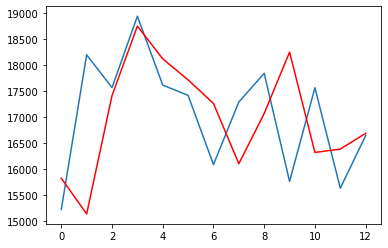

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# split into train and test sets
X = tdf["volume"].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# The following analysis is based on the tutorial with  time series correction
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [176]:
#do Augmented Dickey-Fuller Test(ADF) and calculate rolling statistics to see if our data are stable
def get_stationarity(timeseries):    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation = 45)
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

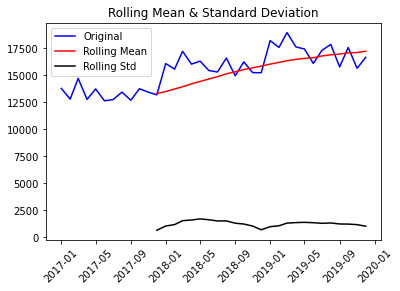

ADF Statistic: -1.8703415796083924
p-value: 0.34613937472857825
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176


In [177]:
get_stationarity(tdf_n["volume"])
#p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.
#the rolling mean and rolling standard deviation increase with time, the time series is not stationary.

In [85]:
tdf.head()

,year-month,volume
0,2017-1,13766
1,2017-2,12769
2,2017-3,14694
3,2017-4,12742
4,2017-5,13717


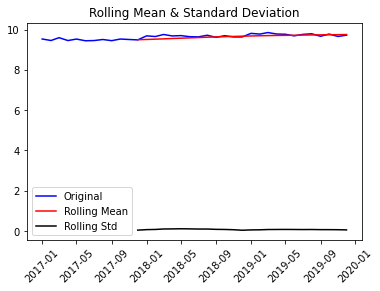

ADF Statistic: -2.104692914663614
p-value: 0.2426317490101993
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176


In [183]:
#do a log conversion
df_log = np.log(tdf_n["volume"])
get_stationarity(df_log)

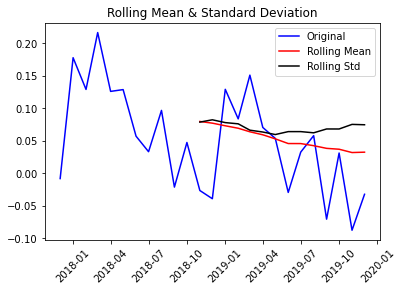

ADF Statistic: -0.8392667559992163
p-value: 0.807314845762099
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445


In [184]:
#subtract the rolling mean
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

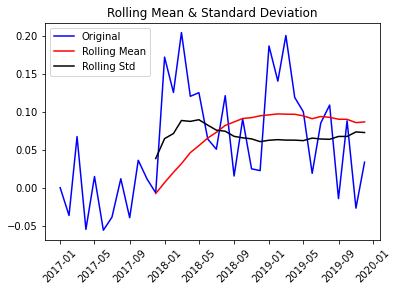

ADF Statistic: -2.9418340655506356
p-value: 0.04069506996819771
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176


In [185]:
#apply exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)


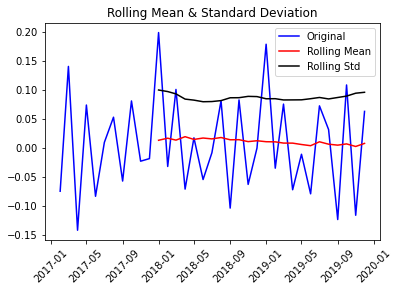

ADF Statistic: -5.561982208725583
p-value: 1.5344597000282403e-06
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176


In [186]:
#apply time shifting, best conversion!
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

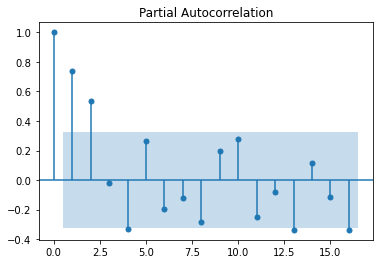

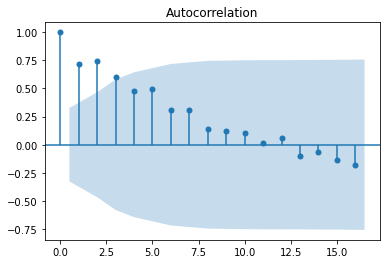

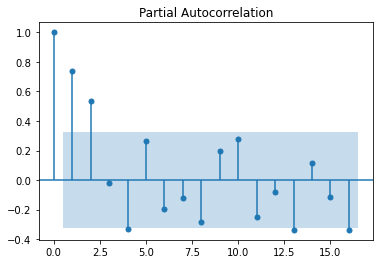

In [187]:
sm.graphics.tsa.plot_acf(df_log) #ARIMA,q
sm.graphics.tsa.plot_pacf(df_log) #ARIMA,p

/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue us

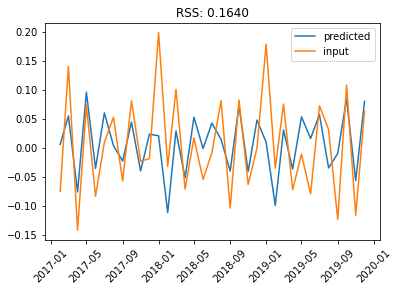

In [210]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(1,1,1))
results = model.fit(disp=-1)
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_log_shift)**2))
plt.plot(results.fittedvalues, label ='predicted')
plt.plot(df_log_shift, label ='input')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

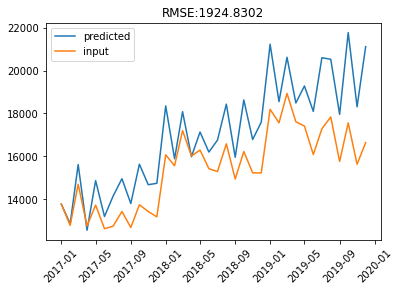

In [262]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = df_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.title('RMSE:%.4f' % sqrt(mean_squared_error(tdf["volume"], predictions_ARIMA)))
plt.plot(predictions_ARIMA, label ='predicted')
plt.plot(tdf_n["volume"], label ='input')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

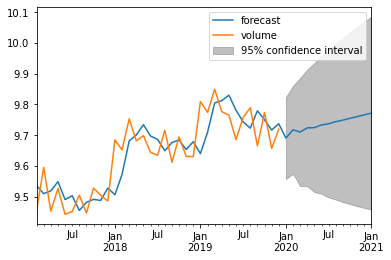

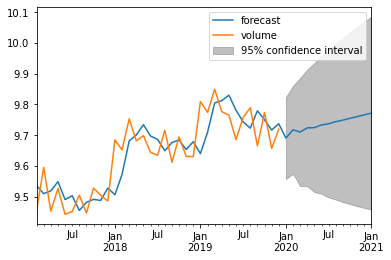

In [197]:
results.plot_predict(1,48)

In [281]:
future = 6
X = df_log_shift.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
pred_future = list(tdf_n["year-month"][size:len(X)])
for i in range(future):
    pred_future.append(pred_future[-1]+relativedelta(months=1))
history = [x for x in train]
predictions = []
# walk-forward validation
for t in range(len(pred_future)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = float(output[0])
    predictions.append(yhat)
    #obs = test[t]
    #history.append(obs)
    history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
#predictions2 = model_fil.predict


/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model

/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model

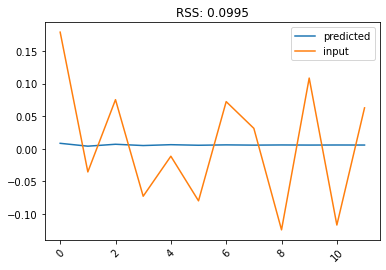

In [283]:
plt.title('RSS: %.4f'% sum((test-predictions[:(len(X)-size)])**2))
plt.plot(predictions[:(len(X)-size)], label ='predicted')
plt.plot(test, label ='input')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

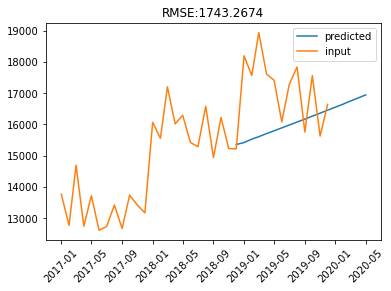

In [293]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series([df_log[0:size][-1]]*len(pred_future)).add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.title('RMSE:%.4f' % sqrt(mean_squared_error(tdf_n["volume"][size:len(X)], predictions_ARIMA[:(len(X)-size)])))
plt.plot(pred_future, predictions_ARIMA, label ='predicted')
plt.plot(tdf_n["year-month"], tdf_n["volume"], label ='input')
plt.legend()
plt.xticks(rotation = 45)
plt.show()